In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv("CarPriceAssignment.csv")

In [4]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [5]:
df = df.dropna()      

In [6]:
df = df.drop_duplicates()

In [7]:
df = pd.get_dummies(df, drop_first=True)

In [8]:
print(df.columns)

Index(['car_ID', 'symboling', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       ...
       'cylindernumber_three', 'cylindernumber_twelve', 'cylindernumber_two',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'fuelsystem_spdi',
       'fuelsystem_spfi'],
      dtype='object', length=191)


In [9]:
X = df[['wheelbase', 'carlength', 'carwidth', 'carheight',
        'curbweight', 'enginesize', 'horsepower',
        'citympg', 'highwaympg']]

y = df['price']


<Axes: xlabel='wheelbase', ylabel='price'>

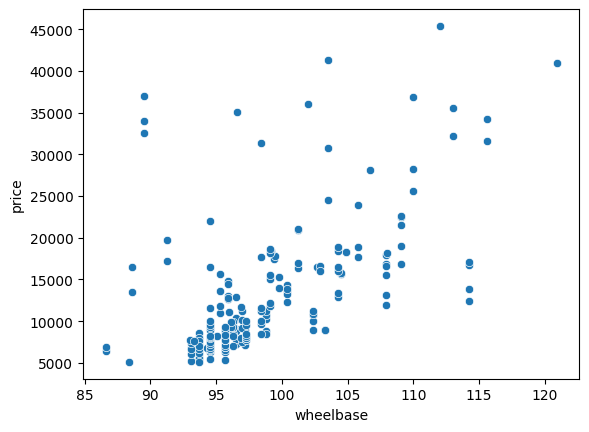

In [10]:
sns.scatterplot(x=df['wheelbase'], y=df['price'])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: -54214.91611480759
Coefficients: [   1.10098347  -62.26509778  720.26695394  217.84334344    1.92324583
   85.70147099   46.86354499 -162.80280253   78.9235166 ]


In [14]:
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae= mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE" , mae)
print("R²:", r2)

MSE: 14317129.271489266
MAE 2704.625079606998
R²: 0.8186420059181644
